In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !pip install tldextract
!pip install fasttext
# !pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199769 sha256=015fc6c44f214dc73edec57aa207b55b02297bdbd39b34787693726a3b70e0e7
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [3]:
from urllib.parse import urlparse
# import tldextract

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from transformers import RobertaTokenizer, RobertaConfig, RobertaModel, RobertaForSequenceClassification
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
import keras
# from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout, Input, Concatenate, LeakyReLU
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model

In [ ]:
phish_df = pd.read_csv('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/ICSX_URL2016_Dataset/phishing_dataset.csv', names=['phishing_url'])
nonphish_df = pd.read_csv('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/ICSX_URL2016_Dataset/Benign_list_big_final.csv', names=['url'])

In [ ]:
phish_df.head()

,phishing_url
0,http://v2.email-marketing.adminsimple.com/trac...
1,http://bid.openx.net/json?amp;amp;amp;amp;cid;...
2,http://webmail2.centurytel.net/hwebmail/servic...
3,http://www.google.com.ng/imgres?imgurl=http://...
4,http://webmail2.centurytel.net/hwebmail/servic...


In [ ]:
nonphish_df.head()

,url
0,http://1337x.to/torrent/1048648/American-Snipe...
1,http://1337x.to/torrent/1110018/Blackhat-2015-...
2,http://1337x.to/torrent/1122940/Blackhat-2015-...
3,http://1337x.to/torrent/1124395/Fast-and-Furio...
4,http://1337x.to/torrent/1145504/Avengers-Age-o...


In [ ]:
phish_df.shape, nonphish_df.shape

((9965, 1), (35378, 1))

### df merge

#### Label

phishing: -1\
genuine: 1

In [ ]:
phish_df['phishing_url']==''

0        False
1        False
2        False
3        False
4        False
         ...  
99918    False
99919    False
99920    False
99921    False
99922    False
Name: phishing_url, Length: 99923, dtype: bool

In [ ]:
df_1 = pd.DataFrame({'url': phish_df['phishing_url'], 'label': -1*np.ones(phish_df.shape[0])})
df_2 = pd.DataFrame({'url': nonphish_df.sample(nonphish_df.shape[0])['url'], 'label': np.ones(nonphish_df.shape[0])})

In [ ]:
df = pd.concat([df_1, df_2]).sample(frac=1, ignore_index=True)

In [ ]:
df.head()

,url,label
0,http://www.jcelectronicsperu.com/welljay/sessi...,-1.0
1,http://sourceforge.net/directory/audio-video/a...,1.0
2,http://allrecipes.com/Recipe/Smoked-Pork-Butt/...,1.0
3,http://doodle.com/ca/premium?utm_source=doodle...,1.0
4,http://extratorrent.cc/torrent/4189401/John+R....,1.0


### data cleaning

In [ ]:
def filter_df(x):
    try:
        scheme = urlparse(str(x))._asdict()['netloc']
        if scheme=='':
            return np.nan
        return x
    except:
        scheme = urlparse(str(x)[:-1])._asdict()['netloc']
        if scheme=='':
            return np.nan
        return x

In [ ]:
df.shape

(45343, 2)

In [ ]:
df['url'] = df['url'].apply(lambda x: filter_df(x))
df.dropna(inplace=True)

In [ ]:
df.shape

(45343, 2)

In [ ]:
urlparse(df['url'][1])._asdict(), urlparse('http://198.50.135.149:80/redirecionamento/tv55lgm.php')._asdict()

({'scheme': 'http',
  'netloc': 'kenh14.vn',
  'path': '/xa-hoi/them-mot-lau-dai-phap-cua-dai-gia-ha-noi-20150508121858684.chn',
  'params': '',
  'query': '',
  'fragment': ''},
 {'scheme': 'http',
  'netloc': '198.50.135.149:80',
  'path': '/redirecionamento/tv55lgm.php',
  'params': '',
  'query': '',
  'fragment': ''})

In [ ]:
def parser(x, key, type):
    try:
        scheme = urlparse(str(x))._asdict()[key]
    except:
        scheme = urlparse(str(x)[:-1])._asdict()[key]

    return pd.Series([scheme], index=[type])


def parse_domain(x):
    subdomain = None
    domain = None
    tld = None
    try:
        scheme = urlparse(str(x))._asdict()['netloc']
        url = tldextract.extract(scheme)
        subdomain, domain, tld = url.subdomain, url.domain, url.suffix
    except:
        scheme = urlparse(str(x)[:-1])._asdict()['netloc']
        url = tldextract.extract(scheme)
        subdomain, domain, tld = url.subdomain, url.domain, url.suffix

    return pd.Series([subdomain, domain, tld], index=['subdomain', 'domain', 'tld'])

In [ ]:
df_protocol = df['url'].apply(lambda x: parser(x, 'scheme', 'protocol'))
df_domain = df['url'].apply(lambda x: parse_domain(x))
df_path = df['url'].apply(lambda x: parser(x, 'path', 'path'))
df_url_length = df['url'].apply(lambda x: len(x)).rename('url_length')

In [ ]:
df_domain.head()

,subdomain,domain,tld
0,www,jcelectronicsperu,com
1,,sourceforge,net
2,,allrecipes,com
3,,doodle,com
4,,extratorrent,cc


In [ ]:
df_protocol.head()

,protocol
0,http
1,http
2,http
3,http
4,http


In [ ]:
df_path.head()

,path
0,/welljay/session.htm
1,/directory/audio-video/add_facet_filter
2,/Recipe/Smoked-Pork-Butt/Detail.aspx
3,/ca/premium
4,/torrent/4189401/John+R.+Pierce+-+Tutto+%28o+q...


In [ ]:
df.shape, df_protocol.shape, df_domain.shape, df_path.shape, df_url_length.shape

((45343, 2), (45343, 1), (45343, 3), (45343, 1), (45343,))

In [ ]:
df.head()

,url,label
0,http://www.jcelectronicsperu.com/welljay/sessi...,-1.0
1,http://sourceforge.net/directory/audio-video/a...,1.0
2,http://allrecipes.com/Recipe/Smoked-Pork-Butt/...,1.0
3,http://doodle.com/ca/premium?utm_source=doodle...,1.0
4,http://extratorrent.cc/torrent/4189401/John+R....,1.0


In [ ]:
filtered_df = pd.concat([df_protocol, df_domain, df_path, df_url_length, df], axis=1)

In [ ]:
filtered_df.head()

,protocol,subdomain,domain,tld,path,url_length,url,label
0,http,www,jcelectronicsperu,com,/welljay/session.htm,52,http://www.jcelectronicsperu.com/welljay/sessi...,-1.0
1,http,,sourceforge,net,/directory/audio-video/add_facet_filter,92,http://sourceforge.net/directory/audio-video/a...,1.0
2,http,,allrecipes,com,/Recipe/Smoked-Pork-Butt/Detail.aspx,86,http://allrecipes.com/Recipe/Smoked-Pork-Butt/...,1.0
3,http,,doodle,com,/ca/premium,87,http://doodle.com/ca/premium?utm_source=doodle...,1.0
4,http,,extratorrent,cc,/torrent/4189401/John+R.+Pierce+-+Tutto+%28o+q...,118,http://extratorrent.cc/torrent/4189401/John+R....,1.0


In [ ]:
filtered_df['protocol'].value_counts()

http     43219
https     2122
ftp          2
Name: protocol, dtype: int64

In [ ]:
filtered_df['tld'].value_counts()

com        24695
net         5615
vn          1282
org         1192
pl          1137
           ...  
help           1
info.pl        1
com.pt         1
ac.id          1
af             1
Name: tld, Length: 230, dtype: int64

In [ ]:
processed_urls = filtered_df[['protocol', 'subdomain', 'domain', 'tld']].apply(' '.join, axis=1)

In [ ]:
processed_url_df = pd.DataFrame({'processed_url': processed_urls, 'url_length': filtered_df['url_length'], 'label': filtered_df['label'] })

In [ ]:
processed_url_df.head()

,processed_url,url_length,label
0,http www jcelectronicsperu com,52,-1.0
1,http sourceforge net,92,1.0
2,http allrecipes com,86,1.0
3,http doodle com,87,1.0
4,http extratorrent cc,118,1.0


In [ ]:
processed_url_df['label'].value_counts()

 1.0    35378
-1.0     9965
Name: label, dtype: int64

In [ ]:
# 0 -> phishing
# 1 -> non-phishing
processed_url_df['label'].replace(-1, 0, inplace=True)

In [ ]:
processed_url_df['label'].value_counts()

1.0    35378
0.0     9965
Name: label, dtype: int64

In [ ]:
processed_url_df['processed_url'] = processed_url_df['processed_url'].apply(lambda x: x.lower())

In [ ]:
processed_url_df.head()

,processed_url,url_length,label
0,http www jcelectronicsperu com,52,0.0
1,http sourceforge net,92,1.0
2,http allrecipes com,86,1.0
3,http doodle com,87,1.0
4,http extratorrent cc,118,1.0


In [4]:
# processed_url_df.to_csv('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/processed_urls_cic_dataset.csv', index=False)
processed_url_df = pd.read_csv('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/processed_urls.csv')

In [5]:
processed_url_df['url_length'] = (processed_url_df['url_length']-processed_url_df['url_length'].min())/(processed_url_df['url_length'].max()-processed_url_df['url_length'].min())

In [6]:
train, test = train_test_split(processed_url_df, test_size=0.3, random_state=42, stratify=processed_url_df['label'])

In [7]:
train.shape, test.shape

((139783, 3), (59907, 3))

In [8]:
train.head()

,processed_url,url_length,label
103726,http ex-mail biz,0.001731,0.0
123352,https express adobe com,0.008158,0.0
118426,https biolase com,0.001731,1.0
16180,https agilityhurdles net,0.011867,1.0
66556,https xn--d1aqfkf xn--p1ai,0.010383,0.0


In [9]:
url_length_train = train['url_length'].values
url_length_test = test['url_length'].values

In [10]:
url_length_train.shape, url_length_test.shape

((139783,), (59907,))

In [11]:
# ft = fasttext.load_model('drive/MyDrive/Semester/MTP/Phishing-Detection/phishing.custom.embedding.150.bin')
ft = fasttext.load_model('drive/MyDrive/Semester/MTP/Phishing-Detection/phishing.custom.embedding.unsupervised.200.bin')

In [12]:
ft.get_dimension()

200

In [13]:
MAX_SEQUENCE_LENGTH = 4
EMBEDDING_DIM = ft.get_dimension()

In [14]:
all_sentences = pd.concat([train, test], axis=0)
tokenizer = Tokenizer(split=' ')
tokenizer.fit_on_texts(all_sentences['processed_url'])
sequences = tokenizer.texts_to_sequences(all_sentences['processed_url'])
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')

## creating embedding matrix

In [15]:
vocab_size = len(word_index) + 1
embedding_matrix = np.random.random((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = None
    try:
        embedding_vector = ft.get_word_vector(word)
    except Exception as e:
        print(word, 'not found', e)
    if embedding_vector is not None:
        embedding_matrix[i, :] = embedding_vector

## build model

In [16]:
def build_model():
    sentence_indices = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='float32')

    embeddings = Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)(sentence_indices)

    X = LSTM(units = 32, return_sequences = True)(embeddings)   #, dropout=0.05, recurrent_dropout=0.15 , return_sequences = True
    X = Dropout(rate = 0.4)(X)
    X = LSTM(units = 16)(X)   #, dropout=0.05, recurrent_dropout=0.15 , return_sequences = True
    X = Dropout(rate = 0.2)(X)
    ip2 = Input(shape=(1,), dtype='float32')
    concat = Concatenate()([X, ip2])
    op = Dense(2, activation='relu')(concat)
    op = Dense(1, activation='sigmoid')(op)

    model = Model(inputs=[sentence_indices, ip2], outputs=op)

    return model

In [17]:
tf.random.set_seed(42)

In [18]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 4, 200)               2720860   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 (None, 4, 32)                29824     ['embedding[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, 4, 32)                0         ['lstm[0][0]']            

In [19]:
train_data = data[:train.shape[0]]
test_data = data[train.shape[0]:]
print(train_data.shape, test_data.shape)

(139783, 4) (59907, 4)


In [20]:
train_data

array([[     3,   1717,     42,    120],
       [     1,    174,    194,      2],
       [     1,  28846,      2,      0],
       ...,
       [     1, 104084,      2,      0],
       [     1, 104085,    301,      2],
       [     1,   8050,    242,      0]], dtype=int32)

In [21]:
X_train, Y_train = train_data, train['label'].values
X_test, Y_test = test_data, test['label'].values

In [22]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
earlyStopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001, verbose=1)

history = model.fit([X_train, url_length_train], Y_train, batch_size=64, epochs=100, validation_split= 0.1, callbacks=[earlyStopping])

Epoch 1/100
1966/1966 [==============================] - 24s 7ms/step - loss: 0.4307 - accuracy: 0.8069 - val_loss: 0.3749 - val_accuracy: 0.8331
Epoch 2/100
1966/1966 [==============================] - 14s 7ms/step - loss: 0.3773 - accuracy: 0.8346 - val_loss: 0.3573 - val_accuracy: 0.8407
Epoch 3/100
1966/1966 [==============================] - 14s 7ms/step - loss: 0.3620 - accuracy: 0.8414 - val_loss: 0.3489 - val_accuracy: 0.8438
Epoch 4/100
1966/1966 [==============================] - 14s 7ms/step - loss: 0.3530 - accuracy: 0.8442 - val_loss: 0.3422 - val_accuracy: 0.8436
Epoch 5/100
1966/1966 [==============================] - 14s 7ms/step - loss: 0.3465 - accuracy: 0.8475 - val_loss: 0.3362 - val_accuracy: 0.8485
Epoch 6/100
1966/1966 [==============================] - 13s 7ms/step - loss: 0.3405 - accuracy: 0.8497 - val_loss: 0.3345 - val_accuracy: 0.8508
Epoch 7/100
1966/1966 [==============================] - 13s 7ms/step - loss: 0.3350 - accuracy: 0.8524 - val_loss: 0.3283 -

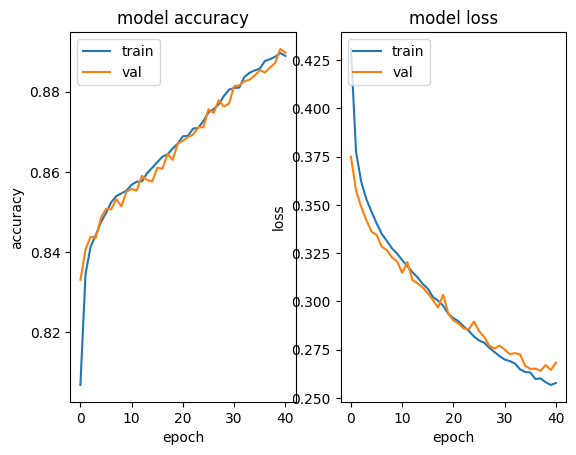

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

# plt.savefig('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/acc_vs_loss_compariasion_lstm.eps', format='eps')
plt.show()

In [24]:
accr = model.evaluate([X_test, url_length_test], Y_test, batch_size=64)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

937/937 [==============================] - 3s 3ms/step - loss: 0.2676 - accuracy: 0.8878
Test set
  Loss: 0.268
  Accuracy: 0.888


In [25]:
y_pred = model.predict([X_test, url_length_test], batch_size=64, verbose=1)
y_pred[y_pred <= 0.5] = 0.
y_pred[y_pred > 0.5] = 1.
print(classification_report(Y_test, y_pred))

937/937 [==============================] - 3s 3ms/step
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.89     29930
         1.0       0.87      0.91      0.89     29977

    accuracy                           0.89     59907
   macro avg       0.89      0.89      0.89     59907
weighted avg       0.89      0.89      0.89     59907



In [ ]:
# model.save('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/phishing_custom_150_model.keras')